In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import cv2 as cv

X = np.load("X.npy")
X.shape

(64, 1, 97656)

In [70]:
X = X.squeeze()

In [42]:
from enum import Enum
from typing import Optional

import numpy as np
from joblib.parallel import Parallel, delayed
from numpy.typing import NDArray
from scipy.fft import rfft


class SensorUnit(Enum):
    milivolt = 'mv'
    volt = 'v'
    gravity = 'g'
    meters = 'a'  # meters per second^2
    inches = '1'  # inches per second^2


def unit_conversion_factor(unit: SensorUnit, ac: float) -> float:
    """Unit conversion factor

    Conversion factor to convert amplitudes to inc/s^2.

    Args:
        unit: unit of the signal. View `SensorUnit`
        ac: Sensor sensitivity in mV/G

    Returns:
        Conversion factor
    """
    m2inch_const = 39.97
    gravity_acceleration_const = 9.80665

    if unit == SensorUnit.milivolt:
        return (m2inch_const / ac) * gravity_acceleration_const
    elif unit == SensorUnit.volt:
        return (m2inch_const / ac) * gravity_acceleration_const * 1000
    elif unit == SensorUnit.gravity:
        return gravity_acceleration_const * m2inch_const
    elif unit == SensorUnit.meters:
        return m2inch_const
    elif unit == SensorUnit.inches:
        return 1.0

    raise RuntimeError(f"Unit '{unit}' not recognized")


def _fft_execute_norm(array, size: int):
    """Execute FFT and normalize amplitudes

    Args:
        array: time series to calculate fft
        size: number of points along transformation axis in the input to use.

    Returns:
        Amplitudes array
    """

    norm_factor = size / 2.0
    amplitudes = rfft(array, n=size)
    amplitudes = amplitudes[:size // 2]
    amplitudes = np.abs(amplitudes) / norm_factor
    return amplitudes


def specialist_fft(
    array: NDArray,
    sample_rate: int,
    unit: SensorUnit = SensorUnit.volt,
    sensor_sensitivity: float = 100.0,
    tunning: float = 1.0,
    n_repetitions: int = 141,
    n_jobs: Optional[int] = None
):
    """Performs specialist FFT

    Args:
        array: Time series to execute FFT.
        sample_rate: Time series sample_rate (per second).
        unit: Unit of the signal (view `SensorUnit`).
        sensor_sensitivity: Sensor sensitivity in mV/G. Not used if `unit` is
            not volt or milivolt.
        tunning: Sensor tunning
        n_repetitions: How many FFTs to execute.
        n_jobs: Maximum number of jobs to use for parallel computation.

    Returns:
        Frequency bins and amplitudes
    """

    array = array / tunning  # Not in-place

    final_spectrum_size = (array.size - n_repetitions + 1) // 2 - 1
    period = sample_rate / (final_spectrum_size + 1) / 2

    parallel = Parallel(n_jobs=n_jobs)
    ffts = parallel(
        delayed(_fft_execute_norm)(array, array.size - i)
        for i in range(n_repetitions)
    )
    ffts_sliced = [x[1:final_spectrum_size + 1] for x in ffts]

    amplitudes = np.max(ffts_sliced, axis=0)
    freq_bins = np.arange(final_spectrum_size) * period + period

    factor = unit_conversion_factor(unit, sensor_sensitivity) / (2 * np.pi)
    amplitudes *= factor / freq_bins

    return freq_bins, amplitudes


In [66]:
def to_spectrogram(array, entry):

    sample_rate = entry

    sample_frequencies, time_segments, spectro = signal.spectrogram(
        array,
        fs=sample_rate,
        nperseg=sample_rate,
        window=('tukey', 0.25),
        scaling='spectrum',
        detrend=False,
        return_onesided=True,
        mode='magnitude')
    sample_frequencies = sample_frequencies[1:]
    spectro = 2 * spectro[1:]

    mask = (sample_frequencies > 0.8) & (sample_frequencies < 130)
    norm_factor = unit_conversion_factor(SensorUnit.volt, 100.0) / (2 * np.pi)

    spectro *= norm_factor / sample_frequencies[:, np.newaxis]
    spectro = np.clip(spectro, 0.0, 1.0)

    spectrogram_image = spectro[mask]
    spectrogram_image = cv.resize(spectrogram_image, [96, 64])

    return spectrogram_image

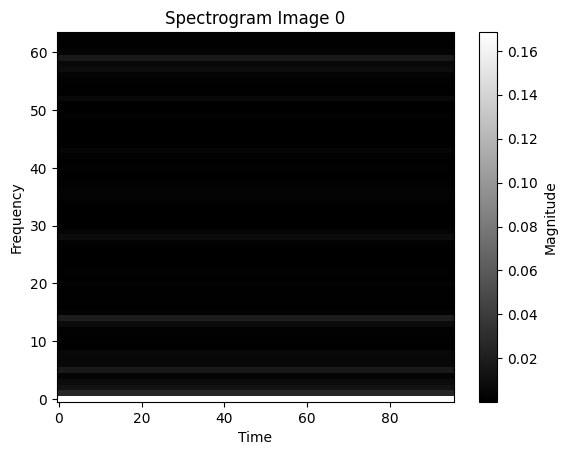

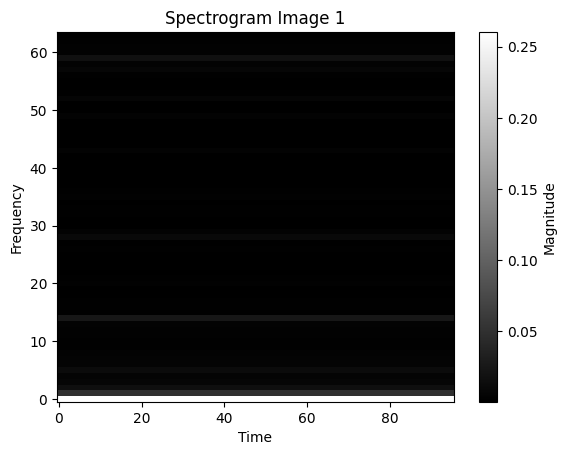

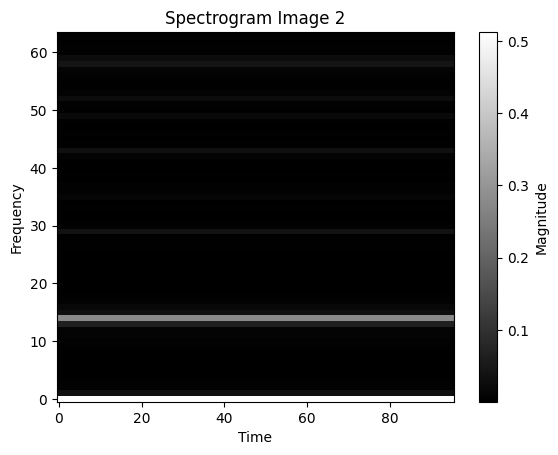

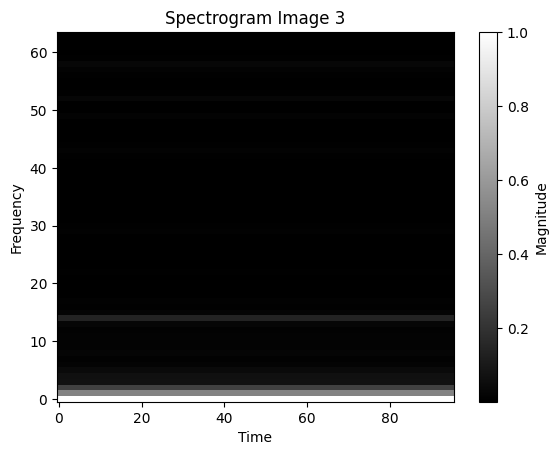

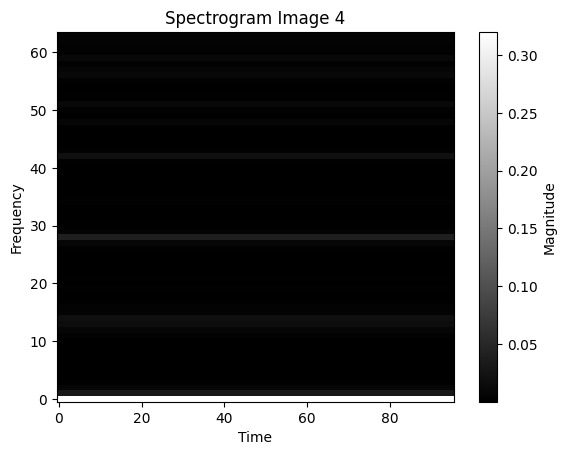

In [73]:
c = 0
for x in X:
    image = to_spectrogram(x, x.shape[-1])

    # Display the spectrogram image using Matplotlib
    plt.imshow(image, cmap='gray', origin='lower', aspect='auto')
    plt.title(f'Spectrogram Image {c}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(label='Magnitude')
    plt.show()
    c += 1
    if(c==5):
        break

In [74]:
features = np.load("features.npy")
features.shape

(64, 128)

In [ ]:
for f in features:
    
    # Display the spectrogram image using Matplotlib
    plt.imshow(image, cmap='gray', origin='lower', aspect='auto')
    plt.title(f'Spectrogram Image {c}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(label='Magnitude')
    plt.show()
    c += 1
    if(c==5):
        break